# Analysis to pick the best token length for SAUR cohort

## Read bed files containing tokens

In [2]:
import os
import pandas as pd
from pathlib import Path


bedDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'bed_files', 'SAUR')

bedDfList = []
for bedFile in os.listdir(bedDir):
    tubeid = bedFile.split('.')[0].split('_')[0]
    tokensDf = pd.read_csv(Path(bedDir, bedFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score'])
    tokensDf['tube_id'] = tubeid
    bedDfList.append(tokensDf)

bedDf = pd.concat(bedDfList, ignore_index=True)
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id
0,1,0,6,TTTTCTT,0.000064,ALF22G140
1,1,7,9,ACC,-0.000395,ALF22G140
2,1,10,13,GACA,0.001573,ALF22G140
3,1,14,18,AGAAT,-0.000986,ALF22G140
4,1,19,25,TAATTAT,0.000795,ALF22G140
...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044
176721939,5,181674,181676,GCA,-0.003468,AH21C044
176721940,5,181677,181680,TCCA,-0.000228,AH21C044


## Calculate token lengths

In [3]:
bedDf['token_length'] = bedDf.tokens.apply(lambda x: len(x))
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
0,1,0,6,TTTTCTT,0.000064,ALF22G140,7
1,1,7,9,ACC,-0.000395,ALF22G140,3
2,1,10,13,GACA,0.001573,ALF22G140,4
3,1,14,18,AGAAT,-0.000986,ALF22G140,5
4,1,19,25,TAATTAT,0.000795,ALF22G140,7
...,...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044,3
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044,6
176721939,5,181674,181676,GCA,-0.003468,AH21C044,3
176721940,5,181677,181680,TCCA,-0.000228,AH21C044,4


## Generate with and without signature files for different token lengths

In [59]:
import os

from pathlib import Path


for tokenLength in range(5, 13):
    print('tokenLength: ', tokenLength)
    tokensDf = bedDf[bedDf.token_length > tokenLength]
    highscoreTokens = list(tokensDf.sort_values(by=['score'], ascending=False).tokens.unique()[:10])
    groupedDf = tokensDf[tokensDf.tokens.isin(highscoreTokens)].groupby(by=['tube_id'])['tokens'].nunique().reset_index().rename(columns={'tokens': 'unique_token_count'})
    uniqueTokenCountCountsDf = groupedDf.unique_token_count.value_counts().reset_index().sort_values(by=['unique_token_count'], ascending=False)
    uniqueTokenCountCountsDf['cumulative_count'] = uniqueTokenCountCountsDf['count'].cumsum()
    uniqueTokenCountCountsDf['cumulative_proportion'] = uniqueTokenCountCountsDf['cumulative_count']/uniqueTokenCountCountsDf['count'].sum()
    uniqueTokenCountCountsDf = uniqueTokenCountCountsDf.sort_values(by=['cumulative_proportion'])
    print('uniqueTokenCountCountsDf: ', uniqueTokenCountCountsDf)
    countCutoff = int(uniqueTokenCountCountsDf[(uniqueTokenCountCountsDf.cumulative_proportion > 0.2)][:1].unique_token_count.values[0])
    print('countCutoff: ', countCutoff)
    withoutSignatureDf = groupedDf[groupedDf.unique_token_count < countCutoff]
    print('without signature: ', withoutSignatureDf.shape[0])
    withSignatureDf = groupedDf[groupedDf.unique_token_count >= countCutoff]
    print('with signature: ', withSignatureDf.shape[0])
    withoutSignatureDf.tube_id.to_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'survival_analysis', 'SAUR', 'tl_' + str(tokenLength) + '_wos_tubeids_v2.txt'), index=False)
    withSignatureDf.tube_id.to_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'survival_analysis', 'SAUR', 'tl_' + str(tokenLength) + '_ws_tubeids_v2.txt'), index=False)

tokenLength:  5
uniqueTokenCountCountsDf:     unique_token_count  count  cumulative_count  cumulative_proportion
0                  10    557               557                    1.0
countCutoff:  10
without signature:  0
with signature:  557
tokenLength:  6
uniqueTokenCountCountsDf:     unique_token_count  count  cumulative_count  cumulative_proportion
0                  10    557               557                    1.0
countCutoff:  10
without signature:  0
with signature:  557
tokenLength:  7
uniqueTokenCountCountsDf:     unique_token_count  count  cumulative_count  cumulative_proportion
0                  10    541               541               0.971275
1                   9     16               557               1.000000
countCutoff:  10
without signature:  16
with signature:  541
tokenLength:  8
uniqueTokenCountCountsDf:     unique_token_count  count  cumulative_count  cumulative_proportion
0                  10    503               503               0.903052
1                

## Run log rank test

In [60]:
import os

from pathlib import Path

import pandas as pd

from lifelines.utils import datetimes_to_durations

from lifelines.statistics import logrank_test


rows = []

journeysDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'data', 'full_cohort', 'journry_times.csv'))
mappingDf = pd.read_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'patient_tube_id_mapping_full.tsv'), sep='\t')[['tube_code', 'PATIENT_ID']].drop_duplicates()
mergedDf = journeysDf.merge(
    mappingDf,
    how='inner',
    left_on='person_id',
    right_on='PATIENT_ID'
).drop(columns=['PATIENT_ID'])


for tokenLength in range(5, 13):
    withoutSignatureTubeidsDf = pd.read_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'survival_analysis', 'SAUR', 'tl_' + str(tokenLength) + '_wos_tubeids_v2.txt'))
    withoutSignatureDf = mergedDf.merge(
        withoutSignatureTubeidsDf,
        how='inner',
        left_on=['tube_code'],
        right_on=['tube_id']
    )
    withoutSignatureDf['cohort'] = 'Without Signature'
    withSignatureTubeidsDf = pd.read_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'survival_analysis', 'SAUR', 'tl_' + str(tokenLength) + '_ws_tubeids_v2.txt'))
    withSignatureDf = mergedDf.merge(
        withSignatureTubeidsDf,
        how='inner',
        left_on=['tube_code'],
        right_on=['tube_id']
    )
    withSignatureDf['cohort'] = 'With Signature'
    conbinedDf = pd.concat([withoutSignatureDf, withSignatureDf], ignore_index=True)

    T, E = datetimes_to_durations(conbinedDf.admittime_adm, conbinedDf.deathtime_adm, freq='D', dayfirst=True)

    conbinedDf['T'] = T
    conbinedDf['E'] = E

    for duration in range(30, 120, 30):

        filteredDf = conbinedDf[(conbinedDf['T'] > 0) & (conbinedDf['T'] < duration)]

        results = logrank_test(
            filteredDf[(filteredDf.cohort == 'With Signature')]['T'],
            filteredDf[(filteredDf.cohort == 'Without Signature')]['T'],
            event_observed_A=filteredDf[(filteredDf.cohort == 'With Signature')]['E'],
            event_observed_B=filteredDf[(filteredDf.cohort == 'Without Signature')]['E'],
            )

        rows.append([tokenLength, duration, results.p_value])
plotDf = pd.DataFrame(rows, columns=['token length', 'journey duration', 'p value'])
plotDf

,token length,journey duration,p value
0,5,30,NaN
1,5,60,NaN
2,5,90,NaN
3,6,30,NaN
4,6,60,NaN
5,6,90,NaN
6,7,30,6.410431e-01
7,7,60,1.292563e-03
8,7,90,6.911440e-04
9,8,30,9.495311e-01


## Visualise p-values

### For different token lengths

<Axes: xlabel='journey duration', ylabel='p value'>

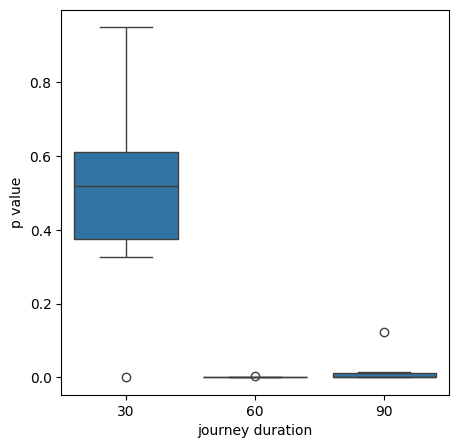

In [61]:
from matplotlib import pyplot as plt
import seaborn as sns


f, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.boxplot(data=plotDf, x='journey duration', y='p value')

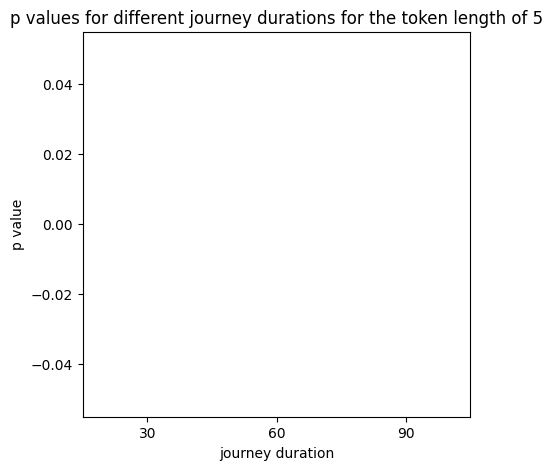

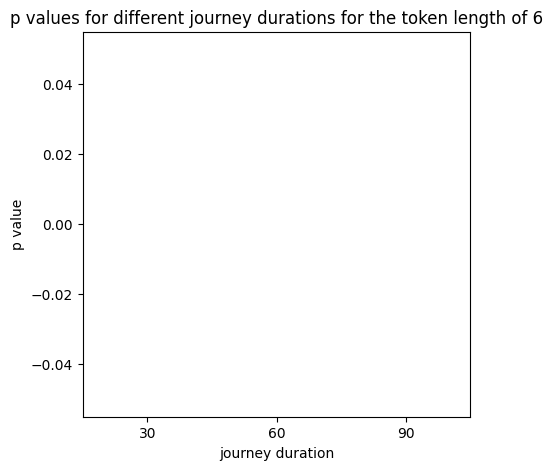

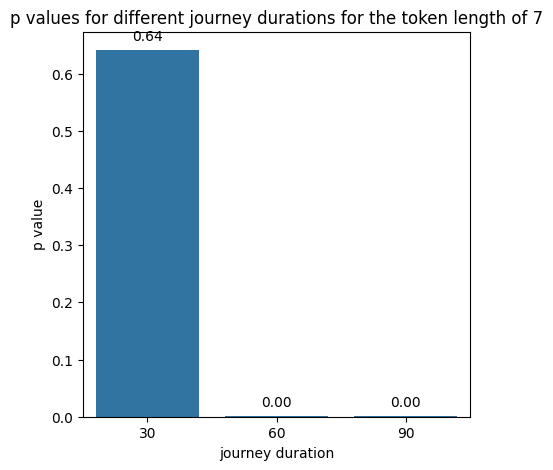

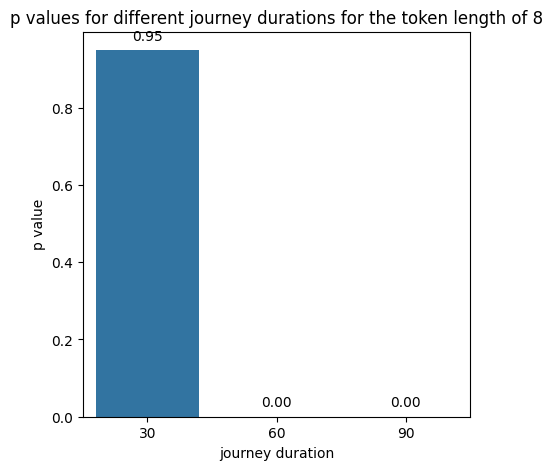

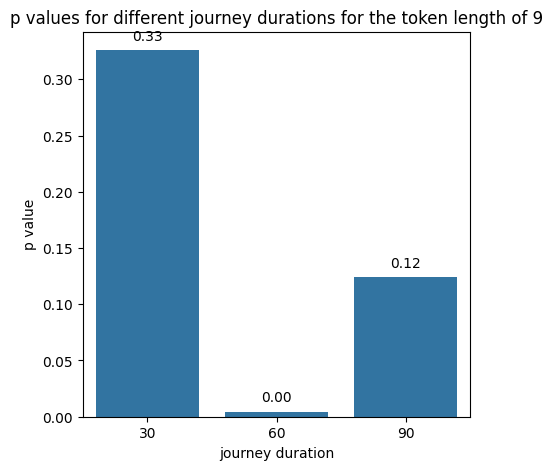

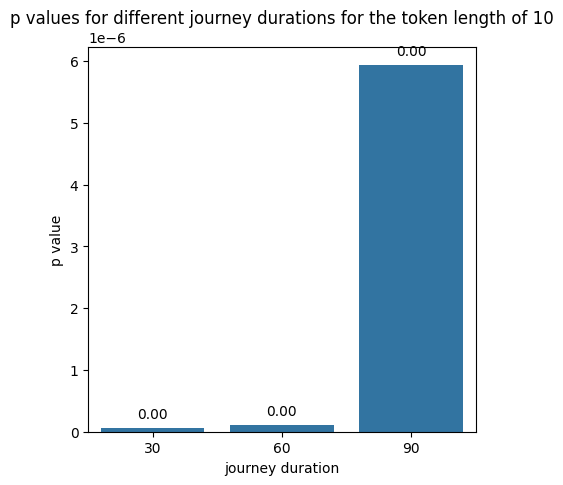

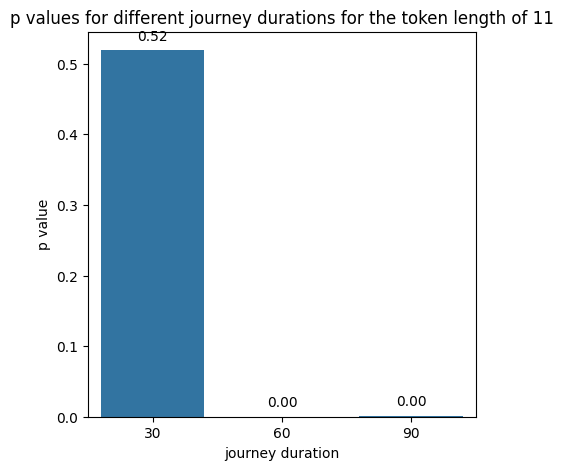

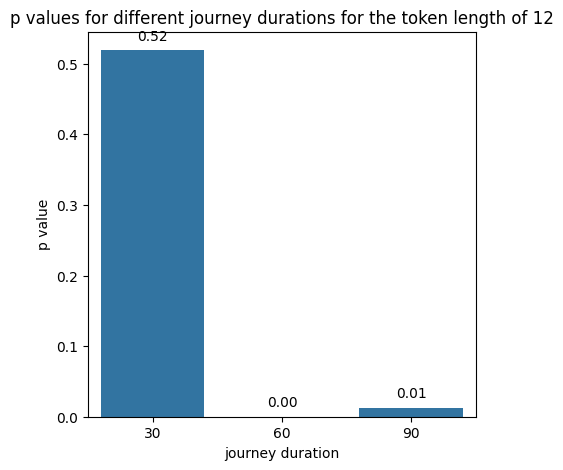

In [62]:
from matplotlib import pyplot as plt
import seaborn as sns


for tokenLength in range(5, 13):
    f, ax = plt.subplots(1, 1, figsize=(5, 5))

    sns.barplot(plotDf[plotDf['token length'] == tokenLength], x='journey duration', y='p value',  ax=ax)

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
    ax.set_title('p values for different journey durations for the token length of ' + str(tokenLength))

    plt.show()

### For different journey durations

<Axes: xlabel='token length', ylabel='p value'>

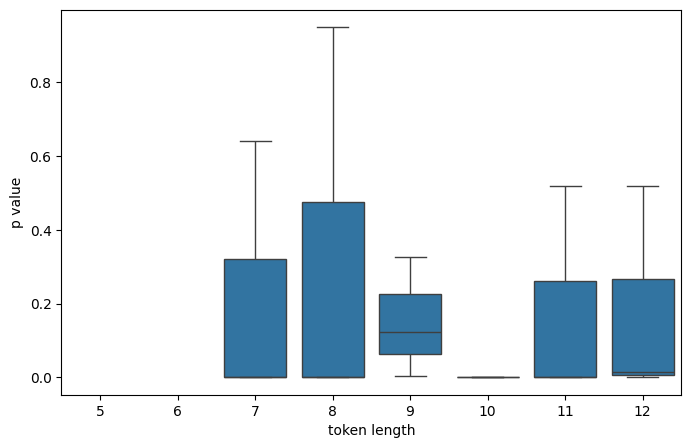

In [63]:
from matplotlib import pyplot as plt
import seaborn as sns


f, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.boxplot(data=plotDf, x='token length', y='p value')

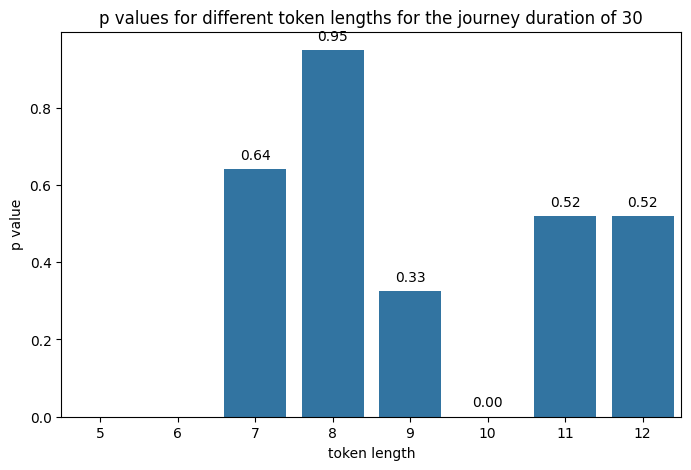

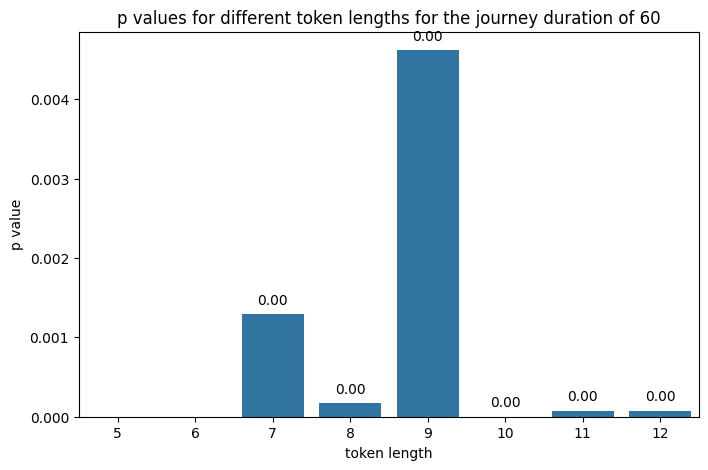

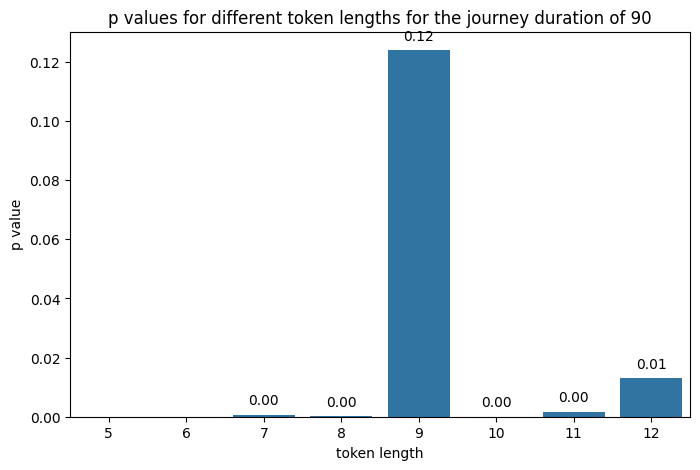

In [64]:
from matplotlib import pyplot as plt
import seaborn as sns


for duration in range(30, 120, 30):
    f, ax = plt.subplots(1, 1, figsize=(8, 5))

    sns.barplot(plotDf[plotDf['journey duration'] == duration], x='token length', y='p value',  ax=ax)

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
    ax.set_title('p values for different token lengths for the journey duration of ' + str(duration))

    plt.show()

### Combined heatmap

In [65]:
heatmapDf = plotDf.pivot_table(index='token length',columns='journey duration', values='p value', aggfunc='mean')
heatmapDf

journey duration,30,60,90
token length,,,
7,6.410431e-01,1.292563e-03,0.000691
8,9.495311e-01,1.730702e-04,0.000081
9,3.259966e-01,4.621438e-03,0.124003
10,6.441874e-08,1.115528e-07,0.000006
11,5.194296e-01,7.652989e-05,0.001724
12,5.194296e-01,7.652989e-05,0.013060


[Text(0.5, 25.722222222222214, 'Duration'),
 Text(33.22222222222222, 0.5, 'Minimum token length')]

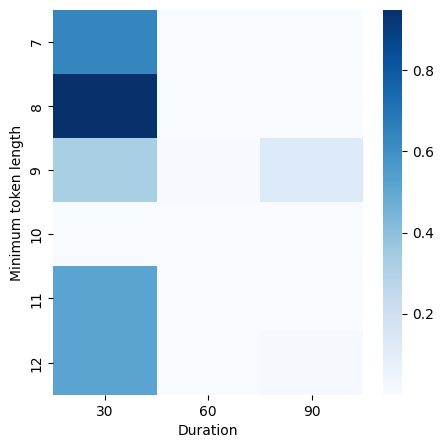

In [66]:
import seaborn as sns

f, ax = plt.subplots(1, 1, figsize=(5, 5))

ax = sns.heatmap(
    heatmapDf,
    # annot=True,
    # fmt=".2f",
    cmap="Blues",
    # vmin=0.6,
    # vmax=0.9,
    # yticklabels=['0', '1', '2'],
    # xticklabels=['1', '2', '3', '4', '5', '6'],
    
)
ax.set(xlabel='Duration', ylabel='Minimum token length')

[Text(0.5, 25.722222222222214, 'Duration'),
 Text(33.22222222222222, 0.5, 'Minimum token length')]

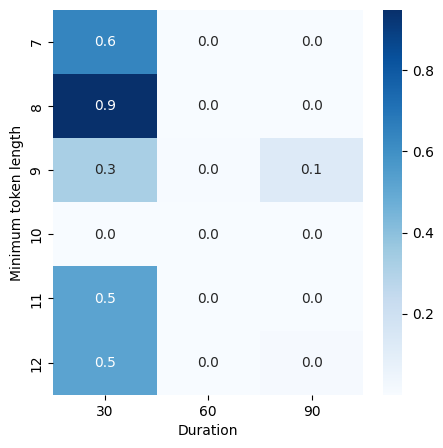

In [67]:
import seaborn as sns

f, ax = plt.subplots(1, 1, figsize=(5, 5))

ax = sns.heatmap(
    heatmapDf,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    # vmin=0.6,
    # vmax=0.9,
    # yticklabels=['0', '1', '2'],
    # xticklabels=['1', '2', '3', '4', '5', '6'],
    
)
ax.set(xlabel='Duration', ylabel='Minimum token length')

In [68]:
plotDf['significant'] = plotDf['p value'] > 0.05
heatmapDf = plotDf.pivot_table(index='token length',columns='journey duration', values='significant')
heatmapDf

journey duration,30,60,90
token length,,,
5,0.0,0.0,0.0
6,0.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,1.0
10,0.0,0.0,0.0
11,1.0,0.0,0.0
12,1.0,0.0,0.0


[Text(0.5, 25.722222222222214, 'Duration'),
 Text(33.22222222222222, 0.5, 'Significant')]

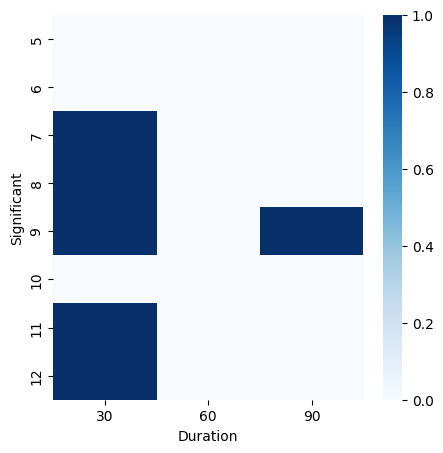

In [69]:
import seaborn as sns

f, ax = plt.subplots(1, 1, figsize=(5, 5))

ax = sns.heatmap(
    heatmapDf,
    # annot=True,
    # fmt=".1f",
    cmap="Blues",
    # vmin=0.6,
    # vmax=0.9,
    # yticklabels=['0', '1', '2'],
    # xticklabels=['1', '2', '3', '4', '5', '6'],
    
)
ax.set(xlabel='Duration', ylabel='Significant')